<a href="https://colab.research.google.com/github/kavyajeetbora/end_to_end_gee_with_python/blob/master/Development/District-Builtup-Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

In [80]:
# Define the time range.
start_date = '1990-01-01'
end_date = '2024-12-31'

# Load the GAUL dataset for second-level administrative units
gaul_dataset = ee.FeatureCollection('FAO/GAUL/2015/level2')
# Filter the dataset to get the boundary of Goa
boundary = gaul_dataset.filter(ee.Filter.eq('ADM1_NAME', 'Assam'))
boundary.size()

## Merge the landsat image collection


- We will merge the landsat images from landsat 5 to landsat 9.
- We will filter the image collection by cloud cover, we want only clean images
- Also print the starting date and ending date of the available image collections

Which images to consider for cloud free images ?

Recommendation:
1. For General Land Cover Mapping and Long-Term Monitoring: Use the Median Composite method to ensure consistent and robust results, especially in areas with frequent cloud cover.
2. For Time-Series Analysis and Short-Term Changes: Use Zero Cloud Cover Images to maintain temporal precision and clarity.

In [81]:
# Function to calculate NDBI for Landsat 7 and 8

def calculate_ndbi_v7(image):
    # Calculate NDBI
    ndbi = image.normalizedDifference(['SR_B4', 'SR_B5']).rename('NDBI')
    return image.addBands(ndbi)

def calculate_ndbi_v8(image):
    # Calculate NDBI
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    return image.addBands(ndbi)

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

In [82]:
%%time
# Load the Landsat image collections.
landsat_collections = [
    "LANDSAT/LT05/C02/T1_L2",  # Landsat 5
    "LANDSAT/LE07/C02/T1_L2",  # Landsat 7
    'LANDSAT/LC08/C02/T1_L2',  # Landsat 8
    'LANDSAT/LC09/C02/T1_L2'   # Landsat 9
]

landsat_images = ee.ImageCollection([])
for collection in landsat_collections:

    image_collection = ee.ImageCollection(collection).filterDate(start_date, end_date)\
        .filterBounds(boundary)\
        .filter(ee.Filter.lt("CLOUD_COVER", 20))  ## images with less than 5% cloud clover

    # Map the function to the image collection
    scaled_image_collection = image_collection.map(apply_scale_factors)

    ## Calculate the index: NDBI:
    if "LT05" in collection or "LE07" in collection:
        new_collection = scaled_image_collection.map(calculate_ndbi_v7)
        print(collection, "Applied ->", "function v7")
    elif "LC08" in collection or "LC09" in collection:
        new_collection = scaled_image_collection.map(calculate_ndbi_v8)
        print(collection, "Applied ->", "function v8")

    landsat_images = landsat_images.merge(new_collection)

# Print the number of images in the combined Landsat collection.
print('\nNumber of images in Landsat collection:', landsat_images.size().getInfo())

first_image = landsat_images.sort('system:index', True).first()
last_image = landsat_images.sort('system:index', False).first()

date1 = first_image.get('DATE_ACQUIRED').getInfo()
date2 = last_image.get('DATE_ACQUIRED').getInfo()

print(f"Images collection are from date: {date1} to {date2}")

LANDSAT/LT05/C02/T1_L2 Applied -> function v7
LANDSAT/LE07/C02/T1_L2 Applied -> function v7
LANDSAT/LC08/C02/T1_L2 Applied -> function v8
LANDSAT/LC09/C02/T1_L2 Applied -> function v8

Number of images in Landsat collection: 4522
Images collection are from date: 1990-01-02 to 2024-04-25
CPU times: user 523 ms, sys: 76.2 ms, total: 599 ms
Wall time: 1min 48s


## Get the number of images for each year

In [83]:
# Function to get the year from the image date
def get_year(image):
    year = ee.Date(image.get('DATE_ACQUIRED')).get('year')
    return year

# Map the function over the image collection to get the list of years
yearly_images = landsat_images.map(lambda image: image.set('year', get_year(image)))

# Reduce the collection by year to count the number of images per year
year_counts = yearly_images.aggregate_histogram('year')

# Print the number of images for each year
print('Number of images for each year:', year_counts.getInfo())

Number of images for each year: {'1990': 49, '1991': 53, '1992': 61, '1993': 55, '1994': 62, '1995': 50, '1996': 70, '1997': 48, '1998': 58, '1999': 115, '2000': 117, '2001': 110, '2002': 74, '2003': 99, '2004': 147, '2005': 120, '2006': 142, '2007': 133, '2008': 151, '2009': 172, '2010': 142, '2011': 164, '2012': 93, '2013': 143, '2014': 202, '2015': 187, '2016': 150, '2017': 190, '2018': 166, '2019': 153, '2020': 162, '2021': 219, '2022': 280, '2023': 279, '2024': 106}


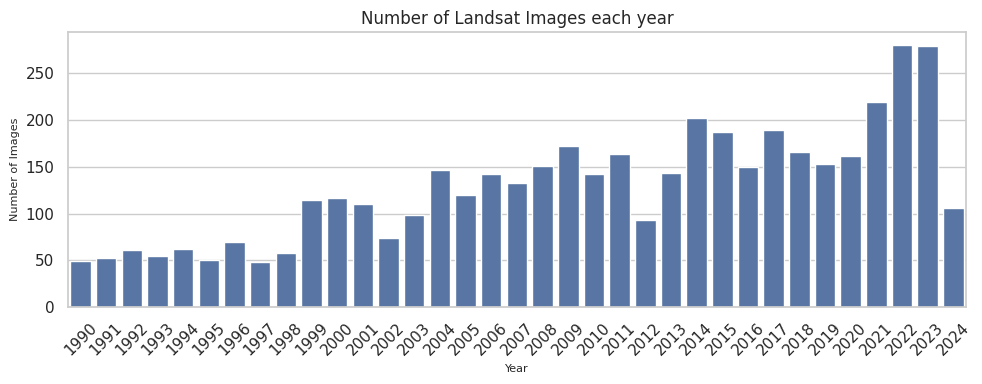

In [84]:
# Function to plot a bar plot from a dictionary
def plot_bar_from_dict(data_dict):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(data_dict.items()), columns=['Category', 'Value'])

    # Set the style of the plot
    sns.set(style="whitegrid")

    # Create the bar plot
    plt.figure(figsize=(10, 4))
    bar_plot = sns.barplot(x='Category', y='Value', data=df)

    # Add titles and labels
    bar_plot.set_title('Number of Landsat Images each year', fontsize=12)
    bar_plot.set_xlabel('Year', fontsize=8)
    bar_plot.set_ylabel('Number of Images', fontsize=8)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_bar_from_dict(year_counts.getInfo())

## Find the yearly composites


- We will find the median composites for each year to get cloud free images
- we will determine this for each year

In [85]:
%%time

def get_yearly_composites(image_collection):

    yearly_composites = []
    for year in year_counts.getInfo().keys():

        img_col = image_collection.filter(ee.Filter.rangeContains('year', int(year), int(year)))

        first_image = img_col.first()

        median_composite = img_col.median().set('year', year) #.copyProperties(first_image)
        yearly_composites.append(median_composite)

    yearly_composites = ee.ImageCollection.fromImages(yearly_composites)
    return yearly_composites

yearly_composites = get_yearly_composites(yearly_images)

# Print the number of images in the yearly image collection
print('Number of images in yearly image collection:', yearly_composites.size().getInfo())

Number of images in yearly image collection: 35
CPU times: user 880 ms, sys: 106 ms, total: 985 ms
Wall time: 3min 8s


## Visualizing the results

In [86]:
year = 1991
image = yearly_composites.filter(ee.Filter.eq('year', str(year))).first()

# Create a map and display the first image
Map = geemap.Map()
Map.centerObject(boundary, 10)

visualization = {
    'bands': ['NDBI'], # NDBI
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'red']
}
# title = f"Year: {image.get('year').getInfo()}"
title = "NDBI"

Map.addLayer(image.clip(boundary), visualization, title)
Map

Map(center=[26.352060685580785, 92.81483911188172], controls=(WidgetControl(options=['position', 'transparent_…

Exporting the image

In [87]:
# # Export the NDBI image to a GeoTIFF file
# export_task = ee.batch.Export.image.toDrive(
#     image=first_image,
#     description='NDBI_Image_Export-2',
#     folder='projects/gee_exports',
#     fileNamePrefix='NDBI_Image-2',
#     scale=30,
#     region=boundary,
#     fileFormat='GeoTIFF'
# )

# # Start the export task
# export_task.start()